In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

# PREPROCESSING

In [2]:
#importando dataset e dropando colunas vazias e sem informação útil
dataset = pd.read_csv("Live.csv").drop(columns = {'status_id','Column1','Column2','Column3','Column4'})
#transformando pra datetime
dataset['status_published'] = dataset['status_published'].astype(str).str.replace("/","-")
dataset['status_published'] = pd.to_datetime(dataset['status_published'])

In [3]:
dataset['day'] = dataset['status_published'].dt.weekday #adiciona o dia da semana
#dataset['month'] = dataset['status_published'].dt.month #adiciona o mes
dataset['hour'] = dataset['status_published'].dt.hour #adiciona a hora
dataset['minute'] = dataset['status_published'].dt.minute #adiciona os minutos

In [4]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
#transformando as labels em atributos numéricos
dataset['status_type'] = encoder.fit_transform(dataset['status_type'])

#dropando a coluna antiga, pois já adicionamos a mesma numerizada
dataset = dataset.drop(columns = {'status_published'})

In [5]:
dataset.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,day,hour,minute
0,3,529,512,262,432,92,3,1,1,0,6,6,0
1,1,150,0,0,150,0,0,0,0,0,5,22,45
2,3,227,236,57,204,21,1,1,0,0,5,6,17
3,1,111,0,0,111,0,0,0,0,0,5,2,29
4,1,213,0,0,204,9,0,0,0,0,2,3,22


In [6]:
#função para fazer o nome das colunas.
def column_name(name, df):
    result = []
    for i in range(len(df.columns)):
        result.append(name + str(i))
    return result

In [7]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
day = pd.DataFrame(ohe.fit_transform(dataset.iloc[:,10:11].values),index = dataset.index).drop(columns = {0})
day.columns = column_name("day",day)
day.shape

(7050, 6)

In [8]:
hour = pd.DataFrame(ohe.fit_transform(dataset.iloc[:,11:12].values)).drop(columns = {0})
hour.columns = column_name("hour",hour)
hour.shape

(7050, 23)

In [9]:
minute = pd.DataFrame(ohe.fit_transform(dataset.iloc[:,12:13].values)).drop(columns = {0})
minute.columns = column_name("minute",minute)
minute.shape

(7050, 59)

In [10]:
dataset = dataset.drop(columns = {'hour','day','minute'})

In [11]:
dataset = dataset.join(hour).join(day).join(minute)

In [12]:
dataset.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,...,minute49,minute50,minute51,minute52,minute53,minute54,minute55,minute56,minute57,minute58
0,3,529,512,262,432,92,3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,150,0,0,150,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,227,236,57,204,21,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,111,0,0,111,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,213,0,0,204,9,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Faremos o PCA para ajudar na visualização dos dados e reduzin a dimensionalidade

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components = 2)
X = pca.fit_transform(dataset)
explained_variance = pca.explained_variance_ratio_

In [15]:
explained_variance.sum()

0.9903888421184636

Com 2 componentes conseguimos ficar com 0.99 de variância

vemos que o PCA nesse caso foi de grande utilidade, visto que transformou um dataframe com dimensão 10 em um de 2 dimensões preservando a variância quase que por completo

# Inicializando com K-means++ 

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

##### Within cluster sums of squares

vamos variar o número de clusters do KMeans e ver como varia o wcss (within-cluster sums of squares)

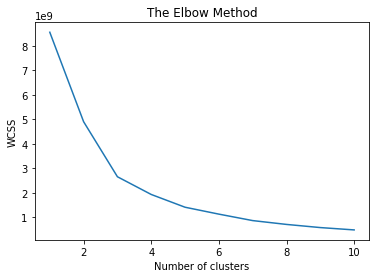

In [17]:
wcss = []
for i in range(1, 11):
    kmeansPP = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeansPP.fit(X)
    wcss.append(kmeansPP.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Nesse método de observação do número de clusters, temos que optar pelo que tem o que seria o maior caimento, ou o mais brusco antes de tornar-se algo parecido com uma reta, visto que a distância entre clusters tende a diminuir de qualquer forma quando aumentamos a quantidade dos mesmos

É visível que o decaimento do WCSS começa a ser mais discreto quando o número de clusters passa de 3. Contudo, vamos olhar o silhouette score antes de tomar qualquer decisão.

##### Silhouette score
é um método melhor para analisar o número ideal de clusters de detreminada análise, pois ela é calculada através das distâncias de cada instância entre as que estão em seu cluster e as que estão nos outros clusters

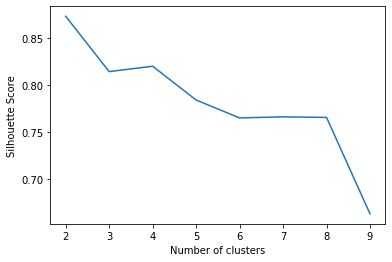

[0.8730739459544392, 0.8142414436840117, 0.819948869650609, 0.7840788926306169, 0.7650068573082058, 0.7661682018388655, 0.7655419930950661, 0.6630087642071462]


In [18]:
sil = []
for i in range(2, 10):
    kmeansPP = KMeans(n_clusters = i, init = 'k-means++', random_state = 0).fit(X)
    labels = kmeansPP.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    #print(sil)
plt.plot(range(2, 10), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
print(sil)

Como a silhouette do 2 ficou relativamente  mais alta, ficaremos com o 2, de forma a priorizar a decisão da silhouette, já que os dois métodos não apresentaram um resultado comum. Tal fato pode ser devido à não normalização dos dados, visto que os dois métodos usados para analisar os resultados são calculados a partir de distâncias.

In [19]:
kmeansPP = KMeans(n_clusters = 2, init = 'k-means++', random_state = 0)
y_kmeansPP = kmeansPP.fit_predict(X)

In [20]:
pd.DataFrame(y_kmeansPP)[0].value_counts()

1    6909
0     141
Name: 0, dtype: int64

In [21]:
y_kmeansPP

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

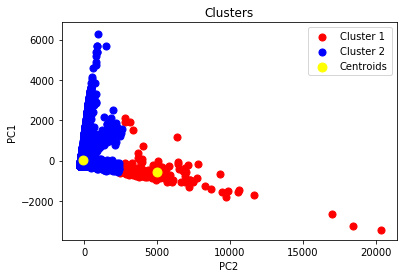

In [22]:
plt.figure(2)
plt.scatter(X[y_kmeansPP == 0, 0], X[y_kmeansPP == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeansPP == 1, 0], X[y_kmeansPP == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(kmeansPP.cluster_centers_[:, 0], kmeansPP.cluster_centers_[:, 1], s = 80, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

# Inicializando aleatoriamente 

vamos variar o número de clusters do KMeans e ver como varia o wcss (within-cluster sums of squares)

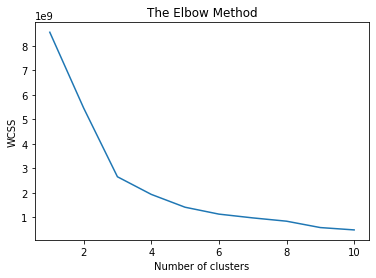

In [23]:
wcss = []
for i in range(1, 11):
    kmeansR= KMeans(n_clusters = i, init = 'random', random_state = 42)
    kmeansR.fit(X)
    wcss.append(kmeansR.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

É visível que a maior inflexão no gráfico é no número 3 e que, portanto, o elbow Method tem como número de clusters 3. Vamos analisar agora a silhouette

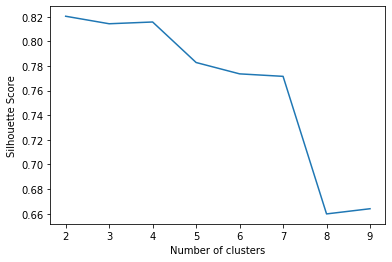

[0.8203416741799345, 0.8142414436840117, 0.8156726956843952, 0.7827758266794018, 0.7735599388962348, 0.7715391993910117, 0.6598419500394265, 0.6640537888263072]


In [24]:
sil = []
for i in range(2, 10):
    kmeansR = KMeans(n_clusters = i, init = 'random', random_state = 42).fit(X)
    labels = kmeansR.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    #print(sil)
plt.plot(range(2, 10), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
print(sil)

Dessa vez, a silhouette ficou muito mais próxima do que no exemplo passado. Como o resultado do elbow Method foi 3, escolhemos 3 também, de forma a levar em consideração os dois métodos.

In [25]:
kmeansR = KMeans(n_clusters = 3, init = 'random', random_state = 0)
y_kmeansR = kmeansR.fit_predict(X)

In [26]:
pd.DataFrame(y_kmeansR)[0].value_counts()

0    6429
1     484
2     137
Name: 0, dtype: int64

In [27]:
y_kmeansR

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

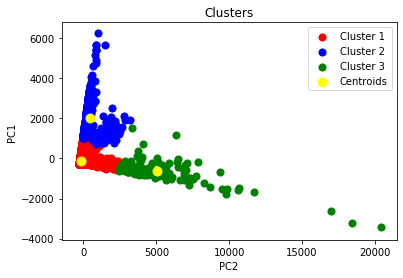

In [28]:
plt.figure(2)
plt.scatter(X[y_kmeansR == 0, 0], X[y_kmeansR == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeansR == 1, 0], X[y_kmeansR == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeansR == 2, 0], X[y_kmeansR == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
#plt.scatter(X[y_kmeansR == 4, 0], X[y_kmeansR == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeansR.cluster_centers_[:, 0], kmeansR.cluster_centers_[:, 1], s = 80, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

Assim ficou a distribuição do nosso cluster com KMeans inicializado aleatoriamente.

# Comparando os Kmeans 

In [29]:
pd.Series(y_kmeansPP).value_counts()

1    6909
0     141
dtype: int64

In [30]:
pd.Series(y_kmeansR).value_counts()

0    6429
1     484
2     137
dtype: int64

Podemos ver que encontramos números diferentes de clusters para cada um dos métodos

In [31]:
kmeansR.cluster_centers_

array([[-144.16234547, -137.71440807],
       [ 479.17130161, 2012.76513186],
       [5072.26867899, -648.26565189]])

In [32]:
kmeansPP.cluster_centers_

array([[5008.21823511, -590.9485825 ],
       [-102.20853541,   12.06017515]])

os centros são iguais nos dois exemplos

# Normalizando os dados e tentando novamente 

In [33]:
X

array([[ 372.67032125,  308.26967385],
       [-242.58568817,  -59.78563909],
       [  11.50161025,  -11.72157772],
       ...,
       [-281.0636605 , -266.10809951],
       [-176.77788529,  216.12639311],
       [-277.08195094, -244.58476106]])

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [35]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [36]:
X_scaled = scaler.fit_transform(X)

In [37]:
X_scaled

array([[-0.93672314, -0.22751206],
       [-0.99623667, -0.30333342],
       [-0.97165888, -0.29343197],
       ...,
       [-0.99995864, -0.34583694],
       [-0.9898711 , -0.24649407],
       [-0.99957349, -0.34140302]])

# Kmeans ++ scaled

Fazendo o wcss // elbow method.

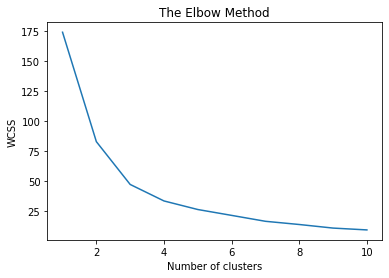

In [38]:
wcss = []
for i in range(1, 11):
    kmeansPPScaled = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeansPPScaled.fit(X_scaled)
    wcss.append(kmeansPPScaled.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

É visível que o decaimento do WCSS começa a ser mais discreto depois do 2, mas fica confuso qual seria o número de clusters

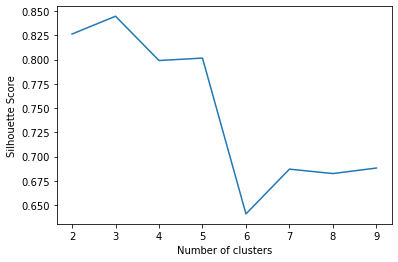

[0.8264458845366237, 0.8447864237542642, 0.7991111893754892, 0.8016086829126319, 0.6408436160201562, 0.6870468242679376, 0.6824741992447427, 0.6881805745669594]


In [39]:
sil = []
for i in range(2, 10):
    kmeansPPScaled = KMeans(n_clusters = i, init = 'k-means++', random_state = 42).fit(X_scaled)
    labels = kmeansPPScaled.labels_
    sil.append(silhouette_score(X_scaled, labels, metric = 'euclidean'))
    #print(sil)
plt.plot(range(2, 10), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
print(sil)

A silhouette score indica 3 como sendo o número ideal de clusters

In [40]:
kmeansPPScaled = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeansPPScaled = kmeansPPScaled.fit_predict(X_scaled)

In [41]:
pd.DataFrame(y_kmeansPPScaled)[0].value_counts()

0    6430
1     483
2     137
Name: 0, dtype: int64

In [42]:
y_kmeansPPScaled

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

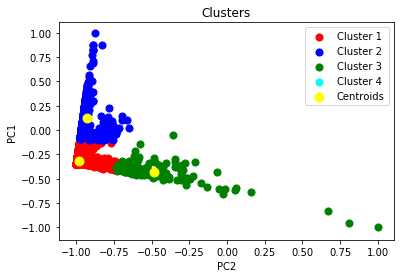

In [43]:
plt.figure(3)
plt.scatter(X_scaled[y_kmeansPPScaled == 0, 0], X_scaled[y_kmeansPPScaled == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X_scaled[y_kmeansPPScaled == 1, 0], X_scaled[y_kmeansPPScaled == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X_scaled[y_kmeansPPScaled == 2, 0], X_scaled[y_kmeansPPScaled == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(X_scaled[y_kmeansPPScaled == 3, 0], X_scaled[y_kmeansPPScaled == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X_scaled[y_kmeansPPScaled == 4, 0], X_scaled[y_kmeansPPScaled == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeansPPScaled.cluster_centers_[:, 0], kmeansPPScaled.cluster_centers_[:, 1], s = 80, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

# Random scaled 

Fazendo o wcss // elbow method.

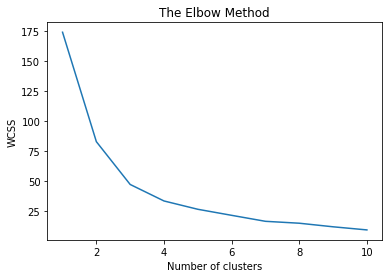

In [44]:
wcss = []
for i in range(1, 11):
    kmeansRscaled= KMeans(n_clusters = i, init = 'random', random_state = 42)
    kmeansRscaled.fit(X_scaled)
    wcss.append(kmeansRscaled.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Mais uma vez depois de 2 ainda temos uma queda significativa no 3. Por isso, vamos checar a silhouette.

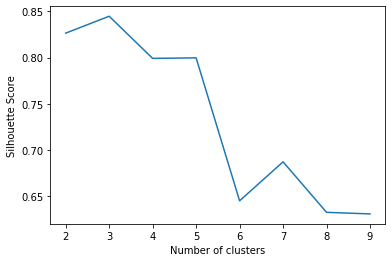

[0.8264458845366237, 0.8447864237542642, 0.7991111893754892, 0.7996722604970022, 0.6447053508555691, 0.686952691029972, 0.6322124484173911, 0.630495219601638]


In [45]:
sil = []
for i in range(2, 10):
    kmeansRscaled = KMeans(n_clusters = i, init = 'random', random_state = 42).fit(X_scaled)
    labels = kmeansRscaled.labels_
    sil.append(silhouette_score(X_scaled, labels, metric = 'euclidean'))
    #print(sil)
plt.plot(range(2, 10), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
print(sil)

A silhouette indica 3 como sendo o melhor número de clusters

In [46]:
kmeansRscaled = KMeans(n_clusters = 3, init = 'random', random_state = 42)
y_kmeansRscaled = kmeansRscaled.fit_predict(X_scaled)

In [47]:
pd.DataFrame(y_kmeansRscaled)[0].value_counts()

1    6430
2     483
0     137
Name: 0, dtype: int64

In [48]:
y_kmeansRscaled

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

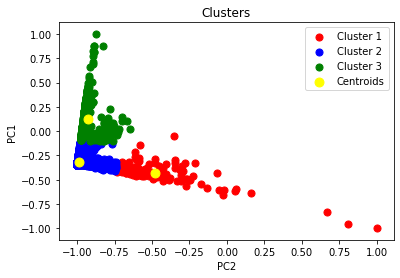

In [49]:
plt.figure(2)
plt.scatter(X_scaled[y_kmeansRscaled == 0, 0], X_scaled[y_kmeansRscaled == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X_scaled[y_kmeansRscaled == 1, 0], X_scaled[y_kmeansRscaled == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X_scaled[y_kmeansRscaled == 2, 0], X_scaled[y_kmeansRscaled == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
#plt.scatter(X_scaled[y_kmeansRscaled == 3, 0], X_scaled[y_kmeansRscaled == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X[y_kmeansR == 4, 0], X[y_kmeansR == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeansRscaled.cluster_centers_[:, 0], kmeansRscaled.cluster_centers_[:, 1], s = 80, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

Nas duas observações feitas com os dados normalizados, encontramos o número de clusters sendo 3

# Comparando todos os resultados finais

In [50]:
print(kmeansPP.cluster_centers_)
pd.Series(y_kmeansPP).value_counts()

[[5008.21823511 -590.9485825 ]
 [-102.20853541   12.06017515]]


1    6909
0     141
dtype: int64

In [51]:
print(kmeansR.cluster_centers_)
pd.Series(y_kmeansR).value_counts()

[[-144.16234547 -137.71440807]
 [ 479.17130161 2012.76513186]
 [5072.26867899 -648.26565189]]


0    6429
1     484
2     137
dtype: int64

In [52]:
print(kmeansPPScaled.cluster_centers_)
pd.Series(y_kmeansPPScaled).value_counts()

[[-0.98662017 -0.31934436]
 [-0.92739605  0.12482155]
 [-0.48276341 -0.42756359]]


0    6430
1     483
2     137
dtype: int64

In [53]:
print(kmeansRscaled.cluster_centers_)
pd.Series(y_kmeansRscaled).value_counts()

[[-0.48276341 -0.42756359]
 [-0.98662017 -0.31934436]
 [-0.92739605  0.12482155]]


1    6430
2     483
0     137
dtype: int64

os resultados deram iguais para os dois depois do scale

### Conclusão

Podemos ver que antes de fazermos a normalização, as métricas usadas para deteterminar o número ideal de clusters não entravam em consenso como fizeram após a normalização e, por isso, tivemos que dispor de uma subjetividade maior antes de fazermos a normalização. Contudo, apesar disso, o kmeans antes da normalização ainda atingiu valores de centro e números de instâncias bem parecidos com os já normalizados. Por fim, vemos que depois de fazermos os scale no nosso dataset, os clusters e seus centros foram os mesmos tanto pro kmeans random quanto pro kmeans++